# Import Library

In [617]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load Dataset

In [618]:
df_train = pd.read_csv('./dataset/train_dataset.csv')
df_test = pd.read_csv('./dataset/test_dataset_no_y.csv')

In [619]:
df_train.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
0,0.407166,E,W,2.0,M,C,1.127628,-0.657689,-0.415323,76.124758,20.710704
1,44.417166,M,W,1.0,H,C,0.957628,-0.667689,-0.475323,85.834758,94.202404
2,28.047166,M,W,4.0,L,R,0.717628,-1.107689,-0.385323,13.814758,43.043004
3,-0.462834,NaN,W,2.0,L,C,1.717628,-1.547689,-0.425323,29.344758,7.956004
4,42.957166,M,W,3.0,M,C,0.747628,-1.847689,-0.135323,NaN,62.397804


In [620]:
df_train['x4'].unique()

array([ 2.,  1.,  4.,  3., nan])

In [621]:
df_test['x4']

0      2.0
1      1.0
2      1.0
3      4.0
4      4.0
      ... 
188    NaN
189    4.0
190    3.0
191    4.0
192    1.0
Name: x4, Length: 193, dtype: float64

In [622]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      757 non-null    float64
 1   x2      760 non-null    object 
 2   x3      762 non-null    object 
 3   x4      764 non-null    float64
 4   x5      758 non-null    object 
 5   x6      761 non-null    object 
 6   x7      761 non-null    float64
 7   x8      756 non-null    float64
 8   x9      763 non-null    float64
 9   x10     758 non-null    float64
 10  y       758 non-null    float64
dtypes: float64(7), object(4)
memory usage: 68.9+ KB


In [623]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      186 non-null    float64
 1   x2      183 non-null    object 
 2   x3      182 non-null    object 
 3   x4      180 non-null    float64
 4   x5      185 non-null    object 
 5   x6      182 non-null    object 
 6   x7      183 non-null    float64
 7   x8      187 non-null    float64
 8   x9      181 non-null    float64
 9   x10     185 non-null    float64
dtypes: float64(6), object(4)
memory usage: 15.2+ KB


# Data Cleaning

In [624]:
df_train.describe()

,x1,x4,x7,x8,x9,x10,y
count,757.000000,764.000000,761.000000,756.000000,763.000000,758.000000,758.000000
mean,24.825200,2.463351,1.749244,-1.179051,-0.323344,59.538307,53.993730
std,20.880903,1.082431,0.861297,0.431568,0.115757,31.805305,42.823339
min,-1.642834,1.000000,0.257628,-1.917689,-0.515323,3.134758,5.120804
25%,9.977166,2.000000,1.007628,-1.557689,-0.425323,33.527258,30.710379
50%,23.217166,2.000000,1.777628,-1.202689,-0.325323,59.799758,45.788304
75%,36.107166,3.000000,2.487628,-0.797689,-0.225323,85.799758,65.293729
max,143.194213,4.000000,3.247628,-0.417689,-0.115323,117.924758,328.493593


## Cek Duplikat Data

In [625]:
df_train.duplicated().sum()

np.int64(0)

In [626]:
df_test.duplicated().sum()

np.int64(0)

## Cek Missing Value

In [627]:
df_train.isna().sum()

x1     43
x2     40
x3     38
x4     36
x5     42
x6     39
x7     39
x8     44
x9     37
x10    42
y      42
dtype: int64

In [628]:
df_train.shape

(800, 11)

In [629]:
df_test.shape

(193, 10)

In [630]:
df_train.isna().sum()

x1     43
x2     40
x3     38
x4     36
x5     42
x6     39
x7     39
x8     44
x9     37
x10    42
y      42
dtype: int64

In [631]:
df_test.isna().sum()

x1      7
x2     10
x3     11
x4     13
x5      8
x6     11
x7     10
x8      6
x9     12
x10     8
dtype: int64

In [632]:
numerical_cols = df_train.drop(['y', 'x4'], axis=1).select_dtypes(['float64']).columns

In [633]:
categorical_cols = df_train.select_dtypes(['object']).columns.to_list()
categorical_cols.append('x4')
test_categorical_cols = df_test.select_dtypes(['object']).columns.to_list()

<Axes: >

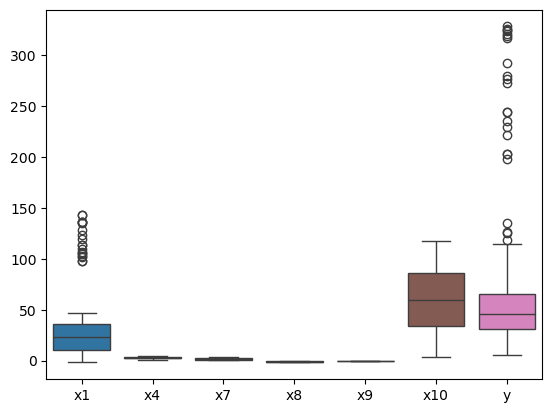

In [634]:
sns.boxplot(df_train)

In [635]:
def handle_outliers_fixed(df):
    numeric_cols = df.select_dtypes(include=['number']).columns
    df_result = df.copy()
    
    for col in numeric_cols:
        Q1 = df_result[col].quantile(0.25)
        Q3 = df_result[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        mean_value = df_result[col].mean()
        
        # Penggantian nilai hanya pada kolom numerik
        outlier_mask = (df_result[col] < lower_bound) | (df_result[col] > upper_bound)
        df_result[col] = df_result[col].where(~outlier_mask, mean_value)

    return df_result

df_train = handle_outliers_fixed(df_train)

<Axes: >

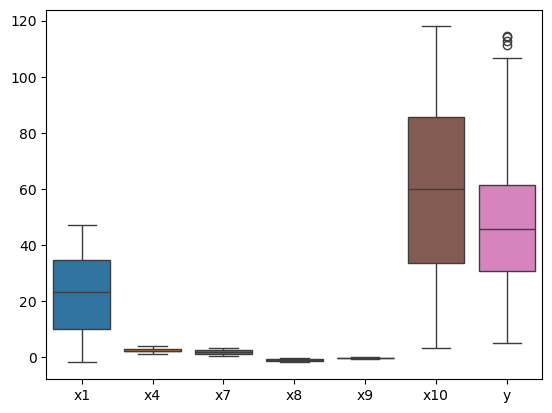

In [636]:
sns.boxplot(df_train)

## Handle Missing Value Variabel Numerik

<Axes: >

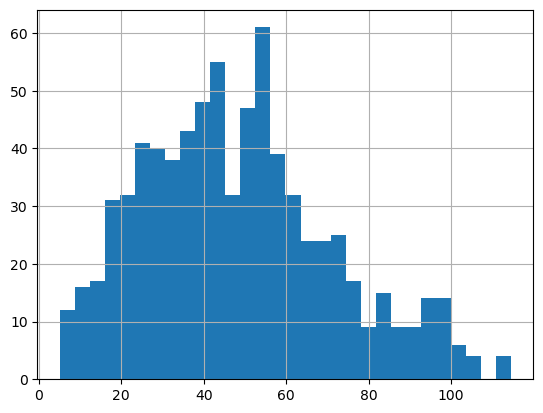

In [637]:
df_train['y'].hist(bins=30)

In [638]:
df_train[numerical_cols]

,x1,x7,x8,x9,x10
0,0.407166,1.127628,-0.657689,-0.415323,76.124758
1,44.417166,0.957628,-0.667689,-0.475323,85.834758
2,28.047166,0.717628,-1.107689,-0.385323,13.814758
3,-0.462834,1.717628,-1.547689,-0.425323,29.344758
4,42.957166,0.747628,-1.847689,-0.135323,NaN
...,...,...,...,...,...
795,18.237166,2.857628,-1.727689,-0.435323,82.144758
796,37.787166,2.147628,-1.747689,-0.315323,32.374758
797,36.127166,0.437628,-0.857689,-0.185323,62.894758
798,32.477166,2.447628,-1.207689,-0.465323,77.094758


array([[<Axes: title={'center': 'x1'}>, <Axes: title={'center': 'x7'}>],
       [<Axes: title={'center': 'x8'}>, <Axes: title={'center': 'x9'}>],
       [<Axes: title={'center': 'x10'}>, <Axes: >]], dtype=object)

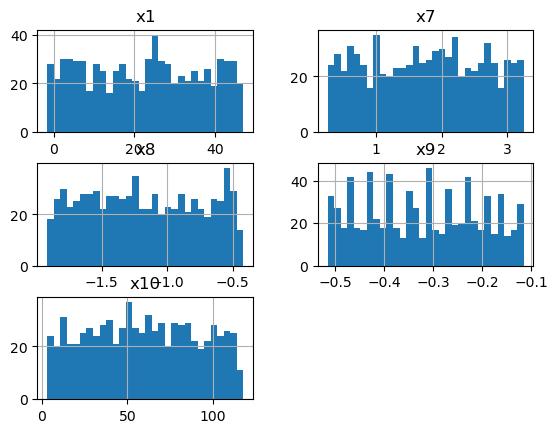

In [639]:
df_train[numerical_cols].hist(bins=30)

## Menghapus Nilai Null pada Variabel Numerik Menggunakan Median karena distribusi data tidak normal

In [640]:
df_train[numerical_cols] = df_train[numerical_cols].fillna(df_train[numerical_cols].mean())

In [641]:
df_train[numerical_cols].isna().sum()

x1     0
x7     0
x8     0
x9     0
x10    0
dtype: int64

In [642]:
df_test[numerical_cols] = df_test[numerical_cols].fillna(df_test[numerical_cols].mean())

## Handle Missing Value Variabel Kategorikal menggunakan Modus

In [643]:
for col in categorical_cols :
    print(f'Jumlah Missing Value pada Data Training Variabel {col}: ', df_train[col].isna().sum())
print('===============================================================================')
for col in categorical_cols :
    print(f'Jumlah Missing Value pada Data Testing Variabel {col}: ', df_test[col].isna().sum())

Jumlah Missing Value pada Data Training Variabel x2:  40
Jumlah Missing Value pada Data Training Variabel x3:  38
Jumlah Missing Value pada Data Training Variabel x5:  42
Jumlah Missing Value pada Data Training Variabel x6:  39
Jumlah Missing Value pada Data Training Variabel x4:  36
Jumlah Missing Value pada Data Testing Variabel x2:  10
Jumlah Missing Value pada Data Testing Variabel x3:  11
Jumlah Missing Value pada Data Testing Variabel x5:  8
Jumlah Missing Value pada Data Testing Variabel x6:  11
Jumlah Missing Value pada Data Testing Variabel x4:  13


In [644]:
print(df_train['x2'].value_counts())
print(df_test['x2'].value_counts())

x2
A    303
M    216
E    162
N     79
Name: count, dtype: int64
x2
A    66
M    64
E    39
N    14
Name: count, dtype: int64


In [645]:
df_train['x2'] = df_train['x2'].fillna('A')
df_test['x2'] = df_test['x2'].fillna('A')

In [646]:
print(df_train['x3'].value_counts())
print(df_test['x3'].value_counts())

x3
W    762
Name: count, dtype: int64
x3
W    182
Name: count, dtype: int64


In [647]:
df_train['x3'] = df_train['x3'].fillna('W')
df_test['x3'] = df_test['x3'].fillna('W')

In [648]:
print(df_train['x5'].value_counts())
print(df_test['x5'].value_counts())

x5
L    313
M    291
H    154
Name: count, dtype: int64
x5
L    83
M    77
H    25
Name: count, dtype: int64


In [649]:
df_train['x5'] = df_train['x5'].fillna('L')
df_test['x5'] = df_test['x5'].fillna('L')

In [650]:
print(df_train['x4'].value_counts())
print(df_test['x4'].value_counts())

x4
3.0    211
2.0    201
1.0    187
4.0    165
Name: count, dtype: int64
x4
4.0    53
1.0    49
2.0    40
3.0    38
Name: count, dtype: int64


In [651]:
df_train['x4'] = df_train['x4'].fillna(3)
df_test['x4'] = df_test['x4'].fillna(4)

In [652]:
print(df_train['x6'].value_counts())
print(df_test['x6'].value_counts())

x6
C    531
R    191
S     39
Name: count, dtype: int64
x6
C    133
R     33
S     16
Name: count, dtype: int64


In [653]:
df_train['x6'] = df_train['x6'].fillna('C')
df_test['x6'] = df_test['x6'].fillna('C')

In [654]:
for col in categorical_cols :
    print(f'Jumlah Missing Value pada Data Training Variabel {col}: ', df_train[col].isna().sum())
print('===============================================================================')
for col in categorical_cols :
    print(f'Jumlah Missing Value pada Data Testing Variabel {col}: ', df_test[col].isna().sum())

Jumlah Missing Value pada Data Training Variabel x2:  0
Jumlah Missing Value pada Data Training Variabel x3:  0
Jumlah Missing Value pada Data Training Variabel x5:  0
Jumlah Missing Value pada Data Training Variabel x6:  0
Jumlah Missing Value pada Data Training Variabel x4:  0
Jumlah Missing Value pada Data Testing Variabel x2:  0
Jumlah Missing Value pada Data Testing Variabel x3:  0
Jumlah Missing Value pada Data Testing Variabel x5:  0
Jumlah Missing Value pada Data Testing Variabel x6:  0
Jumlah Missing Value pada Data Testing Variabel x4:  0


In [655]:
df_train

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
0,0.407166,E,W,2.0,M,C,1.127628,-0.657689,-0.415323,76.124758,20.710704
1,44.417166,M,W,1.0,H,C,0.957628,-0.667689,-0.475323,85.834758,94.202404
2,28.047166,M,W,4.0,L,R,0.717628,-1.107689,-0.385323,13.814758,43.043004
3,-0.462834,A,W,2.0,L,C,1.717628,-1.547689,-0.425323,29.344758,7.956004
4,42.957166,M,W,3.0,M,C,0.747628,-1.847689,-0.135323,59.538307,62.397804
...,...,...,...,...,...,...,...,...,...,...,...
795,18.237166,A,W,4.0,H,R,2.857628,-1.727689,-0.435323,82.144758,30.756604
796,37.787166,A,W,2.0,M,C,2.147628,-1.747689,-0.315323,32.374758,37.879104
797,36.127166,E,W,1.0,L,C,0.437628,-0.857689,-0.185323,62.894758,87.348204
798,32.477166,M,W,1.0,M,C,2.447628,-1.207689,-0.465323,77.094758,55.274904


In [656]:
df_train = df_train.dropna()

In [657]:
df_train.isna().sum()

x1     0
x2     0
x3     0
x4     0
x5     0
x6     0
x7     0
x8     0
x9     0
x10    0
y      0
dtype: int64

In [658]:
df_test.isna().sum()

x1     0
x2     0
x3     0
x4     0
x5     0
x6     0
x7     0
x8     0
x9     0
x10    0
dtype: int64

## One Hot Encoding

In [659]:
df_train = pd.get_dummies(data=df_train, columns=['x2'],dtype='int64', prefix='x2', drop_first=True)
df_train = pd.get_dummies(data=df_train, columns=['x5'],dtype='int64', prefix='x5', drop_first=True)
df_train = pd.get_dummies(data=df_train, columns=['x3'],dtype='int64', prefix='x3')
df_train = pd.get_dummies(data=df_train, columns=['x6'],dtype='int64', prefix='x6', drop_first=True)
df_train

,x1,x4,x7,x8,x9,x10,y,x2_E,x2_M,x2_N,x5_L,x5_M,x3_W,x6_R,x6_S
0,0.407166,2.0,1.127628,-0.657689,-0.415323,76.124758,20.710704,1,0,0,0,1,1,0,0
1,44.417166,1.0,0.957628,-0.667689,-0.475323,85.834758,94.202404,0,1,0,0,0,1,0,0
2,28.047166,4.0,0.717628,-1.107689,-0.385323,13.814758,43.043004,0,1,0,1,0,1,1,0
3,-0.462834,2.0,1.717628,-1.547689,-0.425323,29.344758,7.956004,0,0,0,1,0,1,0,0
4,42.957166,3.0,0.747628,-1.847689,-0.135323,59.538307,62.397804,0,1,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,18.237166,4.0,2.857628,-1.727689,-0.435323,82.144758,30.756604,0,0,0,0,0,1,1,0
796,37.787166,2.0,2.147628,-1.747689,-0.315323,32.374758,37.879104,0,0,0,0,1,1,0,0
797,36.127166,1.0,0.437628,-0.857689,-0.185323,62.894758,87.348204,1,0,0,1,0,1,0,0
798,32.477166,1.0,2.447628,-1.207689,-0.465323,77.094758,55.274904,0,1,0,0,1,1,0,0


In [660]:
df_test = pd.get_dummies(data=df_test, columns=['x2'],dtype='int64', prefix='x2', drop_first=True)
df_test = pd.get_dummies(data=df_test, columns=['x5'],dtype='int64', prefix='x5', drop_first=True)
df_test = pd.get_dummies(data=df_test, columns=['x3'],dtype='int64', prefix='x3')
df_test = pd.get_dummies(data=df_test, columns=['x6'],dtype='int64', prefix='x6', drop_first=True)
df_test

,x1,x4,x7,x8,x9,x10,x2_E,x2_M,x2_N,x5_L,x5_M,x3_W,x6_R,x6_S
0,16.787166,2.0,2.807628,-0.687689,-0.175323,103.314758,0,0,1,1,0,1,0,0
1,38.137166,1.0,2.197628,-0.617689,-0.195323,14.644758,0,1,0,0,1,1,0,0
2,20.797166,1.0,3.007628,-0.687689,-0.235323,41.574758,1,0,0,0,1,1,0,1
3,15.577166,4.0,0.707628,-0.827689,-0.125323,107.614758,0,0,0,0,1,1,0,0
4,44.677166,4.0,3.027628,-0.447689,-0.345323,92.434758,0,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,42.487166,4.0,0.907628,-0.637689,-0.355323,66.764758,0,0,0,0,1,1,1,0
189,-1.162834,4.0,2.697628,-1.147689,-0.435323,85.934758,0,1,0,0,0,1,0,0
190,-1.622834,3.0,2.217628,-0.927689,-0.305323,10.884758,0,0,0,1,0,1,1,0
191,2.137166,4.0,1.877628,-1.627689,-0.245323,56.104758,0,0,0,1,0,1,1,0


## Handle Outlier

In [661]:
df_train.isna().sum()

x1      0
x4      0
x7      0
x8      0
x9      0
x10     0
y       0
x2_E    0
x2_M    0
x2_N    0
x5_L    0
x5_M    0
x3_W    0
x6_R    0
x6_S    0
dtype: int64

# Exploratory Data Analysis

## Cek Korelasi

## Variabel Numerik

In [662]:
df_train[numerical_cols]

,x1,x7,x8,x9,x10
0,0.407166,1.127628,-0.657689,-0.415323,76.124758
1,44.417166,0.957628,-0.667689,-0.475323,85.834758
2,28.047166,0.717628,-1.107689,-0.385323,13.814758
3,-0.462834,1.717628,-1.547689,-0.425323,29.344758
4,42.957166,0.747628,-1.847689,-0.135323,59.538307
...,...,...,...,...,...
795,18.237166,2.857628,-1.727689,-0.435323,82.144758
796,37.787166,2.147628,-1.747689,-0.315323,32.374758
797,36.127166,0.437628,-0.857689,-0.185323,62.894758
798,32.477166,2.447628,-1.207689,-0.465323,77.094758


In [663]:
df_numeric_corr = df_train[['x1', 'x7', 'x8', 'x9', 'x10', 'y']].corr(method='pearson')
df_numeric_corr

,x1,x7,x8,x9,x10,y
x1,1.000000,0.058373,-0.082278,0.012282,-0.035068,0.683990
x7,0.058373,1.000000,-0.011460,-0.038653,-0.009023,0.039024
x8,-0.082278,-0.011460,1.000000,0.036090,0.008816,0.358534
x9,0.012282,-0.038653,0.036090,1.000000,-0.033121,0.275438
x10,-0.035068,-0.009023,0.008816,-0.033121,1.000000,0.330277
y,0.683990,0.039024,0.358534,0.275438,0.330277,1.000000


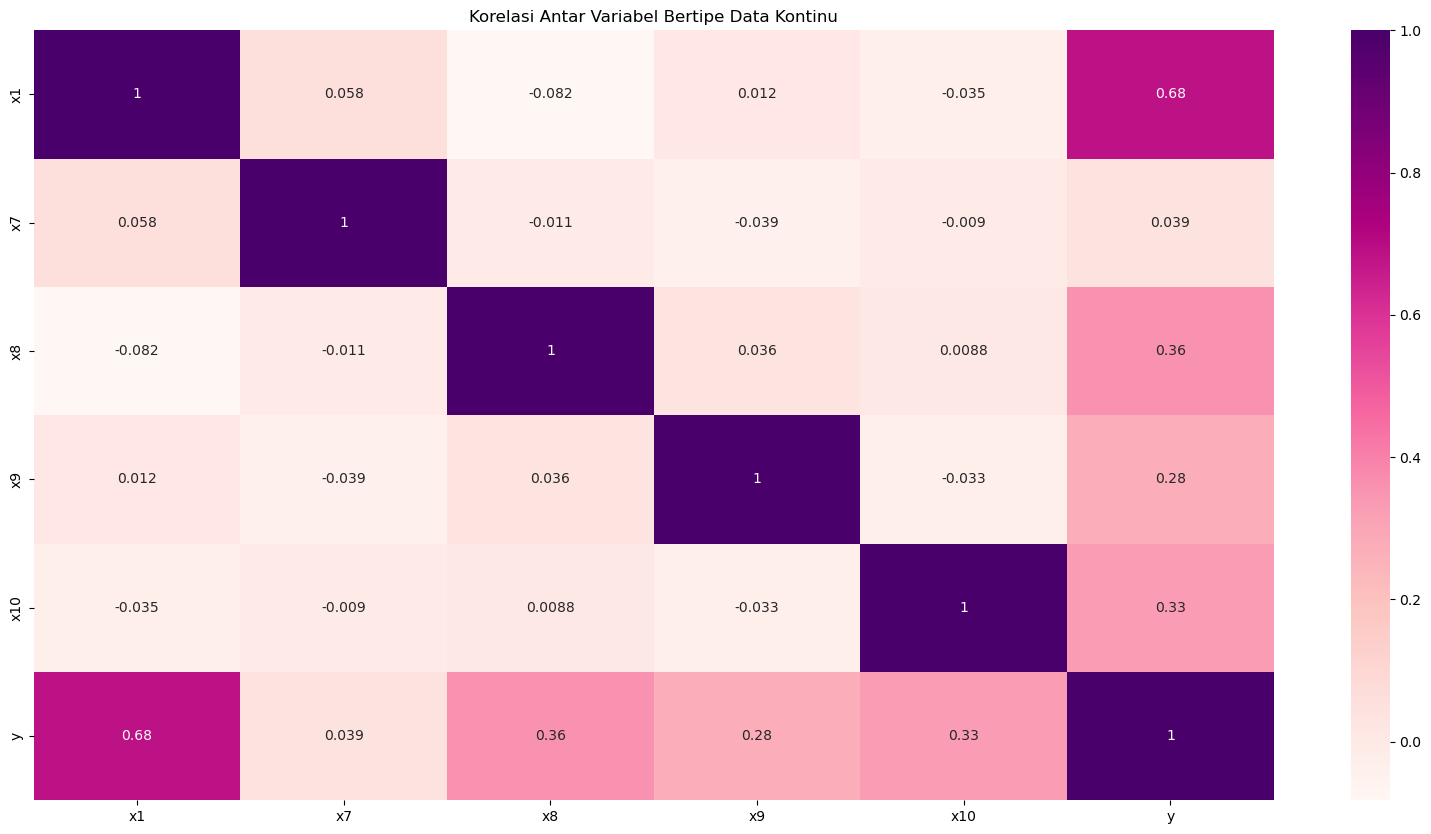

In [664]:
plt.figure(figsize=(20, 10))
plt.title('Korelasi Antar Variabel Bertipe Data Kontinu')
sns.heatmap(df_numeric_corr, annot=True, cmap='RdPu')
plt.show()

## Variabel Kategorik

In [665]:
df_train.describe()

,x1,x4,x7,x8,x9,x10,y,x2_E,x2_M,x2_N,x5_L,x5_M,x3_W,x6_R,x6_S
count,758.000000,758.000000,758.000000,758.000000,758.000000,758.000000,758.000000,758.000000,758.000000,758.000000,758.000000,758.000000,758.0,758.000000,758.000000
mean,22.507067,2.492084,1.742160,-1.182955,-0.322469,59.270187,48.151923,0.208443,0.265172,0.098945,0.439314,0.366755,1.0,0.241425,0.051451
std,13.811754,1.061798,0.839398,0.420869,0.112769,31.119848,22.946474,0.406464,0.441716,0.298785,0.496631,0.482237,0.0,0.428230,0.221062
min,-1.642834,1.000000,0.257628,-1.917689,-0.515323,3.134758,5.120804,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000
25%,10.474666,2.000000,1.037628,-1.547689,-0.415323,34.417258,30.710379,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000
50%,22.468385,3.000000,1.749244,-1.179051,-0.323344,59.538307,45.788304,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000
75%,34.117166,3.000000,2.407628,-0.827689,-0.235323,84.627258,61.516304,0.000000,1.000000,0.000000,1.000000,1.000000,1.0,0.000000,0.000000
max,47.117166,4.000000,3.247628,-0.417689,-0.115323,117.924758,114.482004,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000


## Scaling Data

In [666]:
scaler = StandardScaler()
df_train[numerical_cols] = scaler.fit_transform(df_train[numerical_cols])
df_test[numerical_cols] = scaler.fit_transform(df_test[numerical_cols])

In [667]:
df_train

,x1,x4,x7,x8,x9,x10,y,x2_E,x2_M,x2_N,x5_L,x5_M,x3_W,x6_R,x6_S
0,-1.601136,2.0,-0.732593,1.248874,-0.823942,0.541960,20.710704,1,0,0,0,1,1,0,0
1,1.587385,1.0,-0.935253,1.225098,-1.356354,0.854185,94.202404,0,1,0,0,0,1,0,0
2,0.401380,4.0,-1.221361,0.178953,-0.557736,-1.461622,43.043004,0,1,0,1,0,1,1,0
3,-1.664167,2.0,-0.029245,-0.867192,-0.912677,-0.962254,7.956004,0,0,0,1,0,1,0,0
4,1.481608,3.0,-1.185597,-1.580473,1.660647,0.008621,62.397804,0,1,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,-0.309354,4.0,1.329768,-1.295160,-1.001412,0.735533,30.756604,0,0,0,0,0,1,1,0
796,1.107042,2.0,0.483366,-1.342712,0.063412,-0.864824,37.879104,0,0,0,0,1,1,0,0
797,0.986775,1.0,-1.555154,0.773354,1.216971,0.116548,87.348204,1,0,0,1,0,1,0,0
798,0.722333,1.0,0.841000,-0.058807,-1.267618,0.573150,55.274904,0,1,0,0,1,1,0,0


# Modelling

In [668]:
X = df_train.drop(['y', 'x7', 'x3_W', 'x4'], axis=1)
y = df_train['y']
X_test = df_test.drop(['x7', 'x3_W', 'x4'], axis=1)

In [669]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False)

X_poly = poly.fit_transform(X)
X_test_poly = poly.fit_transform(X_test)

In [670]:
from sklearn.model_selection import train_test_split

In [671]:
X_train, X_val, Y_train, Y_val = train_test_split(
    X_poly, 
    y, 
    test_size=0.25,
    random_state=42 
)

In [672]:
X_constant = sm.add_constant(X_train) 

In [673]:
model = sm.OLS(Y_train, X_constant).fit()

print("Hasil Regresi:")
print(model.summary())

Hasil Regresi:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     76.32
Date:                Tue, 16 Dec 2025   Prob (F-statistic):          1.74e-220
Time:                        09:45:29   Log-Likelihood:                -1922.4
No. Observations:                 568   AIC:                             3977.
Df Residuals:                     502   BIC:                             4263.
Df Model:                          65                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.8208      1.462     

In [674]:
X_val_const = sm.add_constant(X_val)

In [675]:
Y_val_pred = model.predict(X_val_const)

In [676]:
df_train['y'].std()

22.94647369795392

In [677]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


mae = mean_absolute_error(Y_val, Y_val_pred)
rmse = np.sqrt(mean_squared_error(Y_val, Y_val_pred))
r_squared = r2_score(Y_val, Y_val_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R-squared: {r_squared:.4f}")

MAE: 3.7078
RMSE: 5.8973
R-squared: 0.9208


In [678]:
alphas = np.logspace(-5, 2, 8) # Contoh: 8 nilai dari 0.00001 hingga 100
L1_wts = [0.0, 0.25, 0.5, 0.75, 1.0] # 0.0=Ridge, 1.0=Lasso, 0.5=Elastic Net
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_mae_results = {}

for alpha in alphas:
    for L1_wt in L1_wts:
        fold_mae_scores = []
        
        for train_index, val_index in kf.split(X):

            model_tuned = sm.OLS(Y_train, X_constant)
            
            results = model_tuned.fit_regularized(method='elastic_net', 
                                                  alpha=alpha, 
                                                  L1_wt=L1_wt)
            
            coefs = results.params
            Y_pred_val = np.dot(X_val_const, coefs)
            
            current_mae = mean_absolute_error(Y_val, Y_pred_val)
            fold_mae_scores.append(current_mae)
        
        cv_mae_results[(alpha, L1_wt)] = np.mean(fold_mae_scores)

best_params = min(cv_mae_results, key=cv_mae_results.get)
best_mae = cv_mae_results[best_params]

print("\n=============================================")
print("🏆 HASIL HYPERPARAMETER TUNING TERBAIK (Elastic Net)")
print(f"MAE CV Terkecil: {best_mae:.4f}")
print(f"Alpha Terbaik (λ): {best_params[0]:.6f}")
print(f"L1_wt Terbaik (Proporsi Lasso): {best_params[1]:.2f}")
print("=============================================")


🏆 HASIL HYPERPARAMETER TUNING TERBAIK (Elastic Net)
MAE CV Terkecil: 3.4050
Alpha Terbaik (λ): 0.100000
L1_wt Terbaik (Proporsi Lasso): 1.00


In [679]:
model_tuned = sm.OLS(Y_train, X_constant).fit_regularized(alpha=best_params[0], L1_wt=best_params[1])

In [680]:
Y_val_pred_tuned = model_tuned.predict(X_val_const)

In [681]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


mae = mean_absolute_error(Y_val, Y_val_pred_tuned)
rmse = np.sqrt(mean_squared_error(Y_val, Y_val_pred_tuned))
r_squared = r2_score(Y_val, Y_val_pred_tuned)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R-squared: {r_squared:.4f}")

MAE: 3.4050
RMSE: 5.5834
R-squared: 0.9290


In [682]:
X_test = X_test_poly

In [683]:
X_test_const = sm.add_constant(X_test)

In [684]:
y_pred = model.predict(X_test_const)

In [685]:
df_test['y'] = y_pred
df_test

,x1,x4,x7,x8,x9,x10,x2_E,x2_M,x2_N,x5_L,x5_M,x3_W,x6_R,x6_S,y
0,-0.325183,2.0,1.203921,1.245992e+00,1.282483,1.210265,0,0,1,1,0,1,0,0,77.578339
1,1.093977,1.0,0.505445,1.414450e+00,1.101978,-1.486834,0,1,0,0,1,1,0,0,77.326034
2,-0.058633,1.0,1.432929,1.245992e+00,0.740968,-0.667697,1,0,0,0,1,1,0,1,60.004871
3,-0.405613,4.0,-1.200667,9.090777e-01,1.733746,1.341059,0,0,0,0,1,1,0,0,78.489941
4,1.528699,4.0,1.455830,1.823560e+00,-0.251809,0.879325,0,1,0,1,0,1,0,0,102.060805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,1.383127,4.0,-0.971659,1.366319e+00,-0.342062,0.098514,0,0,0,0,1,1,1,0,93.773071
189,-1.518340,4.0,1.077966,1.389870e-01,-1.064082,0.681613,0,1,0,0,0,1,0,0,22.451025
190,-1.548917,3.0,0.528346,6.684243e-01,0.109201,-1.601203,0,0,0,1,0,1,1,0,8.280137
191,-1.298986,4.0,0.139032,-1.016149e+00,0.650716,-0.225734,0,0,0,1,0,1,1,0,23.733271


In [686]:
df_result = pd.DataFrame(y_pred, columns=['y'])
df_result['ID'] = df_result.index + 1
df_result = df_result.reindex(columns=['ID', 'y'])
df_result.to_csv('24083010002-submission-12.csv')

In [687]:
df_result


,ID,y
0,1,77.578339
1,2,77.326034
2,3,60.004871
3,4,78.489941
4,5,102.060805
...,...,...
188,189,93.773071
189,190,22.451025
190,191,8.280137
191,192,23.733271


# Uji Residual

In [688]:
residuals = model.resid

## Uji Normalitas

In [689]:
stat, p_value = shapiro(residuals)
print(f"Uji Normalitas Shapiro-Wilk: Statistik={stat:.4f}, p-value={p_value:.4f}")
if p_value > 0.05:
    print("Residual terdistribusi normal")
else:
    print("Residual tidak normal")

Uji Normalitas Shapiro-Wilk: Statistik=0.7831, p-value=0.0000
Residual tidak normal


## Uji Multikolinearitas

In [690]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data["1/VIF"] = 1 / vif_data["VIF"]
print("\nVIF:\n", vif_data)


VIF:
    feature       VIF     1/VIF
0       x1  1.023176  0.977349
1       x8  1.018782  0.981564
2       x9  1.012067  0.988077
3      x10  1.008363  0.991707
4     x2_E  1.287255  0.776847
5     x2_M  1.458348  0.685708
6     x2_N  1.140714  0.876644
7     x5_L  1.582299  0.631992
8     x5_M  1.532704  0.652442
9     x6_R  1.296673  0.771204
10    x6_S  1.073694  0.931364


## Uji Heteroskedastisitas

In [691]:
bp_test = het_breuschpagan(residuals, X_constant)
labels = ['LM Stat', 'LM p-value', 'F-stat', 'F p-value']
bp_result = dict(zip(labels, bp_test))
print("\nUji Breusch-Pagan:", bp_result)
if bp_result['F p-value'] > 0.05:
    print("Tidak ada heteroskedastisitas")
else:
    print("Ada heteroskedastisitas")


Uji Breusch-Pagan: {'LM Stat': np.float64(131.4504143400358), 'LM p-value': np.float64(0.00011047052550586809), 'F-stat': np.float64(2.3255128280185517), 'F p-value': np.float64(1.9317031286498917e-07)}
Ada heteroskedastisitas


## Uji Autokorelasi

In [692]:
dw_stat = sm.stats.stattools.durbin_watson(residuals)
print(f"\nDurbin-Watson: {dw_stat:.3f}")


Durbin-Watson: 2.068


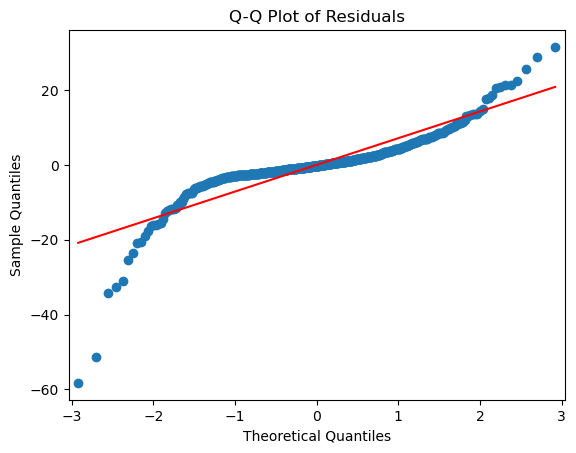

In [693]:
fig = sm.qqplot(residuals, line='s')

# 2. Menambahkan Judul dan Label
plt.title("Q-Q Plot of Residuals")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")

# 3. Menampilkan Plot
plt.show()